In [57]:
import sys
sys.path.insert(1, '../evaluator')

import gc
import itertools
import random as rndm
import numpy as np
import matplotlib.pyplot as plt
from skimage import draw
from evaluator import *
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

%matplotlib inline

In [58]:
'''
evaluator.py
IMPORTS:

getTurbLoc(TURB_LOC_file_name)

loadPowerCurve(POWER_CURVE_file_name)

binWindResourceData(WIND_DATA_file_name)

searchSorted(lookup, sample_array)

preProcessing(POWER_CURVE)

getAEP(TURB_DIAM, turb_coords, POWER_CURVE, WIND_INST_FREQ,
       N_WIND_INSTANCES, COS_DIR, SIN_DIR, WIND_SPEED_STACKED, C_t)
       
checkConstraints(turb_coords, TURB_DIAM)

'''

# Turbine Specifications.
# -**-SHOULD NOT BE MODIFIED-**-
TURB_SPECS    =  {
                     'Name': 'Anon Name',
                     'Vendor': 'Anon Vendor',
                     'Type': 'Anon Type',
                     'Dia (m)': 100,
                     'Rotor Area (m2)': 7853,
                     'Hub Height (m)': 100,
                     'Cut-in Wind Speed (m/s)': 3.5,
                     'Cut-out Wind Speed (m/s)': 25,
                     'Rated Wind Speed (m/s)': 15,
                     'Rated Power (MW)': 3
                 }
TURB_DIAM      =  TURB_SPECS['Dia (m)']
TURB_DIAM       =  TURB_DIAM/2

# Load the power curve
POWER_CURVE   =  loadPowerCurve('./../evaluator/power_curve.csv')

# Pass wind data csv file location to function binWindResourceData.
# Retrieve probabilities of wind instance occurence.
WIND_INST_FREQ =  binWindResourceData('./../evaluator/wind_data/wind_data_2007.csv')

# Doing preprocessing to avoid the same repeating calculations. Record
# the required data for calculations. Do that once. Data are set up (shaped)
# to assist vectorization. Used later in function totalAEP.
N_WIND_INSTANCES, COS_DIR, SIN_DIR, WIND_SPEED_STACKED, C_t = preProcessing(POWER_CURVE)

# check if there is any constraint is violated before we do anything. 
def evalPrint(turbine_coordinates):
    checkConstraints(turbine_coordinates, TURB_DIAM)
    
    print('[INFO] Calculating AEP')
    AEP = getAEP(TURB_DIAM, turbine_coordinates, POWER_CURVE, WIND_INST_FREQ,
                 N_WIND_INSTANCES, COS_DIR, SIN_DIR, WIND_SPEED_STACKED, C_t)
    print('[INFO] Power produced : ', "%.12f"%(AEP), 'GWh')
    
    
# TEST VALUES
# Turbine x,y coordinates
TEST_COORDS   =  getTurbLoc(r'./../test_locations.csv')

In [59]:
%%time
# SELF TEST
_ = checkConstraints(TEST_COORDS, TURB_DIAM)
print("--------######---------")
evalPrint(TEST_COORDS)
print()

[SUCCESS] perimeter and proximity constraints - SATISFIED
--------######---------
[SUCCESS] perimeter and proximity constraints - SATISFIED
[INFO] Calculating AEP
[INFO] Power produced :  505.450636596680 GWh

CPU times: user 125 ms, sys: 15.7 ms, total: 141 ms
Wall time: 153 ms


## Classes

In [68]:
class DNA:
    def __init__(self):
        self.fitness = 0
        self.genes, self.state = self.generate_state()
       
    # GENERATE SET OF VALID GENES
    def generate_state(self):
        state = np.zeros((3900, 3900)).astype(np.int8)
        coordinates = np.array([], dtype=np.int64).reshape(0,2)

        count_placed = 0
        while(count_placed < 50):
            free_coordinates = np.where(state == 0)
            if(len(free_coordinates[0]) == 0): 
                return -1

            free_coordinates = np.stack([*free_coordinates]).transpose()
            chosen_coordinate = rndm.choice(free_coordinates)
            
            r, c = draw.circle(chosen_coordinate[0], chosen_coordinate[1], radius=400, shape=state.shape)
            state[r, c] = 1
            r, c = draw.circle(chosen_coordinate[0], chosen_coordinate[1], radius=50, shape=state.shape)
            state[r, c] = 2

            coordinates = np.concatenate([coordinates, chosen_coordinate.reshape(1,2)], axis=0)
            count_placed += 1

        coordinates = coordinates + 50
        coordinates = coordinates[np.lexsort((coordinates[:,1],coordinates[:,0]))]
        
        return (coordinates.flatten(),  np.pad(state, 50))
        
    # CALC & STORE FITNESS
    def calc_fitness(self):
        if(checkConstraints_F(self.get_tuples(), TURB_DIAM) == -1):
            return 0
        self.fitness = getAEP(TURB_DIAM, self.get_tuples(), POWER_CURVE, WIND_INST_FREQ, 
                              N_WIND_INSTANCES,COS_DIR, SIN_DIR, WIND_SPEED_STACKED, C_t)
        return self.fitness
    
    # GET DNA AS TUPLE OF COORDINATES
    def get_tuples(self):
        return np.reshape(self.genes, newshape=(50,2))
    
    def __getitem__(self, index):
        print("[ERR] USE d.genes[i]")

In [69]:
class Population:
    def __init__(self, population_size, mutation_rate):
        self.best_DNA = None
        self.best_fitness = 0
        self.generations = 0
        
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        
        # SINGLE THREADED POPULATION CREATION
        # self.population = np.array([DNA() for i in range(self.population_size)])
        
        # MULTITHREADED POPULATION CREATION
        processes = []
        with ProcessPoolExecutor(max_workers=4) as executor:
            for _ in range(self.population_size): 
                processes.append(executor.submit(DNA))
        self.population = np.array([processes[i].result() for i in range(self.population_size)])
    
    # CALC & GET FITNESS
    def calc_fitnesses(self):
        return np.array([self.population[i].calc_fitness() for i in range(self.population_size)])
    
    def get_fitnesses(self):
        return np.array([self.population[i].fitness for i in range(self.population_size)])
    
    ########################
    
    # GET DNAs
    def get_population_DNA(self):
        return np.array([self.population[i].get_DNA() for i in range(self.population_size)])
        
    def __getitem__(self, index):
        print("[ERR] USE p.population[i]")

# Main

In [77]:
%%time
# 1
# MULTITHREAD
x = Population(2, 0.1)

CPU times: user 45.8 ms, sys: 92.9 ms, total: 139 ms
Wall time: 13.2 s


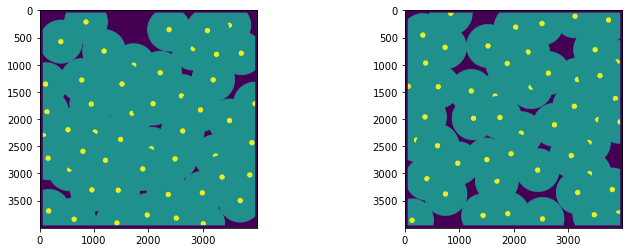

In [78]:
# 1
_, ax = plt.subplots(ncols=2, figsize=(12,4))
for i in range(2):
    ax[i].imshow(x.population[i].state)

In [79]:
display(x.population[0].genes)
display(x.population[0].get_tuples())
display(x.population[0].genes.shape)

array([ 218,  844,  280, 3472,  359, 2368,  377, 3072,  580,  383,  707,
       2810,  753, 1175,  792, 3693,  813, 3238, 1012, 1720, 1150, 2205,
       1281, 3177, 1284,  767, 1358, 1504, 1359,  101, 1575, 2594, 1718,
       2074, 1718, 3945, 1725,  940, 1833, 2945, 1868,  128, 1893, 1689,
       2028, 3478, 2196,  514, 2219, 2619, 2239, 1009, 2304,   65, 2374,
       1479, 2433, 3888, 2544, 2042, 2592,  787, 2679, 3222, 2719,  148,
       2731, 2478, 2757, 1201, 2916, 1886, 2922,  539, 3026, 3850, 3064,
       3341, 3300,  952, 3306, 1435, 3354, 2978, 3385, 2353, 3496, 3673,
       3686,  159, 3761, 1967, 3818, 2500, 3839,  626, 3907, 1412, 3921,
       2995])

array([[ 218,  844],
       [ 280, 3472],
       [ 359, 2368],
       [ 377, 3072],
       [ 580,  383],
       [ 707, 2810],
       [ 753, 1175],
       [ 792, 3693],
       [ 813, 3238],
       [1012, 1720],
       [1150, 2205],
       [1281, 3177],
       [1284,  767],
       [1358, 1504],
       [1359,  101],
       [1575, 2594],
       [1718, 2074],
       [1718, 3945],
       [1725,  940],
       [1833, 2945],
       [1868,  128],
       [1893, 1689],
       [2028, 3478],
       [2196,  514],
       [2219, 2619],
       [2239, 1009],
       [2304,   65],
       [2374, 1479],
       [2433, 3888],
       [2544, 2042],
       [2592,  787],
       [2679, 3222],
       [2719,  148],
       [2731, 2478],
       [2757, 1201],
       [2916, 1886],
       [2922,  539],
       [3026, 3850],
       [3064, 3341],
       [3300,  952],
       [3306, 1435],
       [3354, 2978],
       [3385, 2353],
       [3496, 3673],
       [3686,  159],
       [3761, 1967],
       [3818, 2500],
       [3839,

(100,)

In [80]:
x.calc_fitnesses()

array([510.38722595, 512.43416885])

In [81]:
x.get_fitnesses()

array([510.38722595, 512.43416885])